In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 126
epochs = 500
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
e_list = (0,5,9,49,99,149,199,249,299,349,399,449,499,549,599,649,699,749,799,849,899,949,999,1099,1199)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform,
)

In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


In [8]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)


In [9]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator


In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

def save_generator_image(image, path):
    save_image(image, path)


In [11]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [13]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [14]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    if(epoch in e_list):
        generated_img = generator(noise).cpu().detach()
        # make the images as grid
        generated_img = make_grid(generated_img)
        # save the generated torch tensor models to disk
        save_generator_image(generated_img, f"drive/MyDrive/GAN_outputs1/gen_img{epoch}.png")
        images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), 'drive/MyDrive/gen_state/generator.pth')

477it [00:14, 33.40it/s]
  1%|          | 4/476 [00:00<00:15, 31.45it/s]

Epoch 0 of 500
Generator loss: 3.10782981, Discriminator loss: 0.93533158


477it [00:14, 32.58it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.45it/s]

Epoch 1 of 500
Generator loss: 1.77265334, Discriminator loss: 0.97794533


477it [00:14, 33.44it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.83it/s]

Epoch 2 of 500
Generator loss: 2.26499867, Discriminator loss: 1.01624215


477it [00:14, 33.75it/s]                         
  1%|          | 3/476 [00:00<00:17, 26.61it/s]

Epoch 3 of 500
Generator loss: 1.74742115, Discriminator loss: 1.01344025


477it [00:14, 33.21it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.26it/s]

Epoch 4 of 500
Generator loss: 2.28625107, Discriminator loss: 0.72897124


477it [00:14, 32.93it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.04it/s]

Epoch 5 of 500
Generator loss: 2.69278002, Discriminator loss: 0.53150672


477it [00:14, 33.20it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.41it/s]

Epoch 6 of 500
Generator loss: 2.75142598, Discriminator loss: 0.49872437


477it [00:14, 33.04it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.37it/s]

Epoch 7 of 500
Generator loss: 2.70956779, Discriminator loss: 0.51787376


477it [00:14, 33.50it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.22it/s]

Epoch 8 of 500
Generator loss: 2.62314367, Discriminator loss: 0.59533370


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.77it/s]

Epoch 9 of 500
Generator loss: 2.24725103, Discriminator loss: 0.64056414


477it [00:14, 33.19it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.50it/s]

Epoch 10 of 500
Generator loss: 2.00034237, Discriminator loss: 0.72649539


477it [00:14, 33.52it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.28it/s]

Epoch 11 of 500
Generator loss: 2.09001923, Discriminator loss: 0.69586474


477it [00:14, 32.90it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.17it/s]

Epoch 12 of 500
Generator loss: 2.11754632, Discriminator loss: 0.70388085


477it [00:14, 32.83it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.48it/s]

Epoch 13 of 500
Generator loss: 2.15367556, Discriminator loss: 0.71444690


477it [00:14, 33.83it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.44it/s]

Epoch 14 of 500
Generator loss: 2.08355880, Discriminator loss: 0.73616177


477it [00:14, 33.48it/s]                         
  1%|          | 3/476 [00:00<00:15, 29.72it/s]

Epoch 15 of 500
Generator loss: 1.99421287, Discriminator loss: 0.76322019


477it [00:14, 33.83it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.94it/s]

Epoch 16 of 500
Generator loss: 1.91264164, Discriminator loss: 0.80424803


477it [00:14, 33.41it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.17it/s]

Epoch 17 of 500
Generator loss: 1.90108955, Discriminator loss: 0.79875219


477it [00:14, 33.96it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.59it/s]

Epoch 18 of 500
Generator loss: 2.08274984, Discriminator loss: 0.73870713


477it [00:14, 33.61it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.89it/s]

Epoch 19 of 500
Generator loss: 1.94252288, Discriminator loss: 0.78577977


477it [00:14, 33.85it/s]                         
  1%|          | 3/476 [00:00<00:16, 29.42it/s]

Epoch 20 of 500
Generator loss: 1.89168191, Discriminator loss: 0.80161136


477it [00:14, 33.30it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.72it/s]

Epoch 21 of 500
Generator loss: 1.87287819, Discriminator loss: 0.78631818


477it [00:13, 34.08it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.87it/s]

Epoch 22 of 500
Generator loss: 1.74181747, Discriminator loss: 0.85712826


477it [00:14, 33.44it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.95it/s]

Epoch 23 of 500
Generator loss: 1.69649982, Discriminator loss: 0.86512309


477it [00:14, 33.92it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.77it/s]

Epoch 24 of 500
Generator loss: 1.71877778, Discriminator loss: 0.86660147


477it [00:14, 33.81it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.25it/s]

Epoch 25 of 500
Generator loss: 1.59976530, Discriminator loss: 0.91869235


477it [00:14, 33.63it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.82it/s]

Epoch 26 of 500
Generator loss: 1.62085474, Discriminator loss: 0.89647394


477it [00:14, 33.09it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.67it/s]

Epoch 27 of 500
Generator loss: 1.61132717, Discriminator loss: 0.91353488


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.88it/s]

Epoch 28 of 500
Generator loss: 1.53475702, Discriminator loss: 0.92701155


477it [00:13, 34.34it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.50it/s]

Epoch 29 of 500
Generator loss: 1.52311814, Discriminator loss: 0.95840192


477it [00:14, 33.47it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.59it/s]

Epoch 30 of 500
Generator loss: 1.46596801, Discriminator loss: 0.97531915


477it [00:14, 33.77it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.14it/s]

Epoch 31 of 500
Generator loss: 1.53147840, Discriminator loss: 0.94675094


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.26it/s]

Epoch 32 of 500
Generator loss: 1.44616616, Discriminator loss: 0.97367030


477it [00:14, 33.48it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.58it/s]

Epoch 33 of 500
Generator loss: 1.51265693, Discriminator loss: 0.95078385


477it [00:14, 33.25it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.30it/s]

Epoch 34 of 500
Generator loss: 1.45964050, Discriminator loss: 0.98458123


477it [00:14, 33.48it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.11it/s]

Epoch 35 of 500
Generator loss: 1.40257668, Discriminator loss: 0.99675906


477it [00:13, 34.13it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.23it/s]

Epoch 36 of 500
Generator loss: 1.36736894, Discriminator loss: 1.02615464


477it [00:14, 33.85it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.55it/s]

Epoch 37 of 500
Generator loss: 1.38083124, Discriminator loss: 1.01018989


477it [00:14, 33.34it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.87it/s]

Epoch 38 of 500
Generator loss: 1.41697156, Discriminator loss: 1.00233185


477it [00:14, 33.61it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.06it/s]

Epoch 39 of 500
Generator loss: 1.38182390, Discriminator loss: 1.01867032


477it [00:14, 33.59it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.24it/s]

Epoch 40 of 500
Generator loss: 1.35352123, Discriminator loss: 1.03196204


477it [00:14, 33.65it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.64it/s]

Epoch 41 of 500
Generator loss: 1.35435200, Discriminator loss: 1.02709925


477it [00:14, 33.79it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.57it/s]

Epoch 42 of 500
Generator loss: 1.36227298, Discriminator loss: 1.02462924


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.58it/s]

Epoch 43 of 500
Generator loss: 1.37036610, Discriminator loss: 1.02875614


477it [00:14, 33.50it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.94it/s]

Epoch 44 of 500
Generator loss: 1.33569705, Discriminator loss: 1.04169810


477it [00:14, 33.66it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.36it/s]

Epoch 45 of 500
Generator loss: 1.32820117, Discriminator loss: 1.04462755


477it [00:14, 33.74it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.29it/s]

Epoch 46 of 500
Generator loss: 1.30673516, Discriminator loss: 1.05574882


477it [00:14, 33.89it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.09it/s]

Epoch 47 of 500
Generator loss: 1.28099489, Discriminator loss: 1.06105196


477it [00:14, 33.72it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.43it/s]

Epoch 48 of 500
Generator loss: 1.25989568, Discriminator loss: 1.07853258


477it [00:14, 33.82it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.15it/s]

Epoch 49 of 500
Generator loss: 1.24773943, Discriminator loss: 1.08408856


477it [00:14, 33.81it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.11it/s]

Epoch 50 of 500
Generator loss: 1.20570421, Discriminator loss: 1.10137832


477it [00:13, 34.11it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.72it/s]

Epoch 51 of 500
Generator loss: 1.18377745, Discriminator loss: 1.10883451


477it [00:13, 34.26it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.61it/s]

Epoch 52 of 500
Generator loss: 1.18620551, Discriminator loss: 1.11769354


477it [00:13, 34.20it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.16it/s]

Epoch 53 of 500
Generator loss: 1.18152523, Discriminator loss: 1.10815251


477it [00:14, 33.85it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.97it/s]

Epoch 54 of 500
Generator loss: 1.21271217, Discriminator loss: 1.10180283


477it [00:14, 32.92it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.25it/s]

Epoch 55 of 500
Generator loss: 1.18469608, Discriminator loss: 1.11925626


477it [00:14, 33.24it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.26it/s]

Epoch 56 of 500
Generator loss: 1.19818830, Discriminator loss: 1.11298680


477it [00:14, 33.19it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.76it/s]

Epoch 57 of 500
Generator loss: 1.15135622, Discriminator loss: 1.13614821


477it [00:14, 33.77it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.36it/s]

Epoch 58 of 500
Generator loss: 1.15516222, Discriminator loss: 1.12210178


477it [00:14, 33.88it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.62it/s]

Epoch 59 of 500
Generator loss: 1.13959658, Discriminator loss: 1.13376975


477it [00:14, 33.36it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.51it/s]

Epoch 60 of 500
Generator loss: 1.14383054, Discriminator loss: 1.14163327


477it [00:14, 33.30it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.46it/s]

Epoch 61 of 500
Generator loss: 1.11921334, Discriminator loss: 1.14554715


477it [00:14, 33.96it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.93it/s]

Epoch 62 of 500
Generator loss: 1.10189605, Discriminator loss: 1.15670657


477it [00:14, 33.87it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.84it/s]

Epoch 63 of 500
Generator loss: 1.08523870, Discriminator loss: 1.16672492


477it [00:14, 33.84it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.04it/s]

Epoch 64 of 500
Generator loss: 1.13037956, Discriminator loss: 1.14559793


477it [00:14, 33.49it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.19it/s]

Epoch 65 of 500
Generator loss: 1.13227975, Discriminator loss: 1.14380729


477it [00:14, 33.50it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.70it/s]

Epoch 66 of 500
Generator loss: 1.08581710, Discriminator loss: 1.16279733


477it [00:14, 33.79it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.10it/s]

Epoch 67 of 500
Generator loss: 1.09640181, Discriminator loss: 1.16627038


477it [00:13, 34.26it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.01it/s]

Epoch 68 of 500
Generator loss: 1.07967508, Discriminator loss: 1.17238402


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.35it/s]

Epoch 69 of 500
Generator loss: 1.08350956, Discriminator loss: 1.16434622


477it [00:14, 33.42it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.39it/s]

Epoch 70 of 500
Generator loss: 1.05516458, Discriminator loss: 1.18306398


477it [00:13, 34.08it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.29it/s]

Epoch 71 of 500
Generator loss: 1.10734308, Discriminator loss: 1.16759539


477it [00:14, 33.58it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.67it/s]

Epoch 72 of 500
Generator loss: 1.05663550, Discriminator loss: 1.18178272


477it [00:14, 33.90it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.11it/s]

Epoch 73 of 500
Generator loss: 1.05958092, Discriminator loss: 1.18166137


477it [00:14, 33.73it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.63it/s]

Epoch 74 of 500
Generator loss: 1.05621481, Discriminator loss: 1.18883610


477it [00:14, 33.98it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.36it/s]

Epoch 75 of 500
Generator loss: 1.04768860, Discriminator loss: 1.18678832


477it [00:14, 33.35it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.82it/s]

Epoch 76 of 500
Generator loss: 1.03804159, Discriminator loss: 1.19054878


477it [00:14, 33.82it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.93it/s]

Epoch 77 of 500
Generator loss: 1.04258227, Discriminator loss: 1.19160771


477it [00:14, 32.97it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.96it/s]

Epoch 78 of 500
Generator loss: 1.04196310, Discriminator loss: 1.19554198


477it [00:14, 33.17it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.45it/s]

Epoch 79 of 500
Generator loss: 1.02471745, Discriminator loss: 1.20327520


477it [00:13, 34.27it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.95it/s]

Epoch 80 of 500
Generator loss: 1.02690053, Discriminator loss: 1.19810081


477it [00:13, 34.19it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.88it/s]

Epoch 81 of 500
Generator loss: 1.02906632, Discriminator loss: 1.19690001


477it [00:14, 33.61it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.89it/s]

Epoch 82 of 500
Generator loss: 1.03052986, Discriminator loss: 1.20095217


477it [00:14, 34.05it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.16it/s]

Epoch 83 of 500
Generator loss: 0.99253684, Discriminator loss: 1.21584082


477it [00:13, 34.47it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.60it/s]

Epoch 84 of 500
Generator loss: 1.00403130, Discriminator loss: 1.21598399


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.94it/s]

Epoch 85 of 500
Generator loss: 1.02032447, Discriminator loss: 1.20412767


477it [00:14, 33.95it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.18it/s]

Epoch 86 of 500
Generator loss: 0.99649006, Discriminator loss: 1.21419692


477it [00:14, 33.76it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.56it/s]

Epoch 87 of 500
Generator loss: 0.99932659, Discriminator loss: 1.21622539


477it [00:14, 33.80it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.19it/s]

Epoch 88 of 500
Generator loss: 0.99665093, Discriminator loss: 1.22023189


477it [00:14, 33.45it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.89it/s]

Epoch 89 of 500
Generator loss: 1.03971207, Discriminator loss: 1.20246220


477it [00:14, 33.74it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.14it/s]

Epoch 90 of 500
Generator loss: 1.02993906, Discriminator loss: 1.19889426


477it [00:14, 33.40it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.61it/s]

Epoch 91 of 500
Generator loss: 0.99797136, Discriminator loss: 1.21488488


477it [00:14, 33.53it/s]                         
  1%|          | 3/476 [00:00<00:15, 29.56it/s]

Epoch 92 of 500
Generator loss: 0.98267335, Discriminator loss: 1.22577965


477it [00:14, 33.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.99it/s]

Epoch 93 of 500
Generator loss: 0.98067749, Discriminator loss: 1.22810113


477it [00:14, 33.89it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.67it/s]

Epoch 94 of 500
Generator loss: 0.98158079, Discriminator loss: 1.23154259


477it [00:14, 33.43it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.60it/s]

Epoch 95 of 500
Generator loss: 0.98915058, Discriminator loss: 1.22314012


477it [00:14, 33.54it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.62it/s]

Epoch 96 of 500
Generator loss: 0.97400659, Discriminator loss: 1.22847605


477it [00:14, 33.94it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.84it/s]

Epoch 97 of 500
Generator loss: 0.97728330, Discriminator loss: 1.23267674


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.20it/s]

Epoch 98 of 500
Generator loss: 0.99273354, Discriminator loss: 1.22726583


477it [00:14, 33.65it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.20it/s]

Epoch 99 of 500
Generator loss: 0.95779842, Discriminator loss: 1.23565209


477it [00:14, 33.24it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.02it/s]

Epoch 100 of 500
Generator loss: 0.96451992, Discriminator loss: 1.23312199


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.66it/s]

Epoch 101 of 500
Generator loss: 0.97560829, Discriminator loss: 1.23078203


477it [00:14, 34.06it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.08it/s]

Epoch 102 of 500
Generator loss: 0.96367079, Discriminator loss: 1.23303163


477it [00:14, 33.35it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.54it/s]

Epoch 103 of 500
Generator loss: 0.95975161, Discriminator loss: 1.24399149


477it [00:13, 34.27it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.98it/s]

Epoch 104 of 500
Generator loss: 0.96168220, Discriminator loss: 1.24543309


477it [00:13, 34.27it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.90it/s]

Epoch 105 of 500
Generator loss: 0.94442290, Discriminator loss: 1.24789035


477it [00:13, 34.18it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.22it/s]

Epoch 106 of 500
Generator loss: 0.93399972, Discriminator loss: 1.25385249


477it [00:14, 33.91it/s]                         
  1%|          | 3/476 [00:00<00:17, 27.51it/s]

Epoch 107 of 500
Generator loss: 0.94281042, Discriminator loss: 1.24470484


477it [00:14, 33.92it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.45it/s]

Epoch 108 of 500
Generator loss: 0.97164142, Discriminator loss: 1.24610877


477it [00:13, 34.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.07it/s]

Epoch 109 of 500
Generator loss: 0.94506502, Discriminator loss: 1.24190629


477it [00:14, 34.04it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.66it/s]

Epoch 110 of 500
Generator loss: 0.95414913, Discriminator loss: 1.24388611


477it [00:13, 34.13it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.47it/s]

Epoch 111 of 500
Generator loss: 0.93921435, Discriminator loss: 1.25315642


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.13it/s]

Epoch 112 of 500
Generator loss: 0.93826169, Discriminator loss: 1.24868584


477it [00:14, 33.88it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.74it/s]

Epoch 113 of 500
Generator loss: 0.96457231, Discriminator loss: 1.24468195


477it [00:14, 33.95it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.66it/s]

Epoch 114 of 500
Generator loss: 0.94196051, Discriminator loss: 1.24621201


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.68it/s]

Epoch 115 of 500
Generator loss: 0.94278991, Discriminator loss: 1.25243115


477it [00:14, 33.64it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.01it/s]

Epoch 116 of 500
Generator loss: 0.95049804, Discriminator loss: 1.24805737


477it [00:14, 33.49it/s]
  1%|          | 4/476 [00:00<00:14, 33.01it/s]

Epoch 117 of 500
Generator loss: 0.94739252, Discriminator loss: 1.24565661


477it [00:14, 33.77it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.24it/s]

Epoch 118 of 500
Generator loss: 0.95330524, Discriminator loss: 1.24652362


477it [00:14, 33.91it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.18it/s]

Epoch 119 of 500
Generator loss: 0.94184798, Discriminator loss: 1.24818742


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.18it/s]

Epoch 120 of 500
Generator loss: 0.94475162, Discriminator loss: 1.25135994


477it [00:13, 34.14it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.02it/s]

Epoch 121 of 500
Generator loss: 0.93343085, Discriminator loss: 1.25690603


477it [00:14, 33.86it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.59it/s]

Epoch 122 of 500
Generator loss: 0.94740683, Discriminator loss: 1.25406718


477it [00:14, 33.87it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.57it/s]

Epoch 123 of 500
Generator loss: 0.93484610, Discriminator loss: 1.25332010


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.50it/s]

Epoch 124 of 500
Generator loss: 0.94045275, Discriminator loss: 1.24583912


477it [00:14, 33.27it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.32it/s]

Epoch 125 of 500
Generator loss: 0.93920261, Discriminator loss: 1.25108242


477it [00:14, 33.33it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.55it/s]

Epoch 126 of 500
Generator loss: 0.94224453, Discriminator loss: 1.25722134


477it [00:14, 33.62it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.84it/s]

Epoch 127 of 500
Generator loss: 0.94221437, Discriminator loss: 1.25251341


477it [00:14, 34.06it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.30it/s]

Epoch 128 of 500
Generator loss: 0.93101263, Discriminator loss: 1.25802410


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.97it/s]

Epoch 129 of 500
Generator loss: 0.93011504, Discriminator loss: 1.25211477


477it [00:14, 33.75it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.57it/s]

Epoch 130 of 500
Generator loss: 0.92136806, Discriminator loss: 1.26371360


477it [00:14, 34.04it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.73it/s]

Epoch 131 of 500
Generator loss: 0.93520653, Discriminator loss: 1.25870109


477it [00:14, 34.00it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.38it/s]

Epoch 132 of 500
Generator loss: 0.93916988, Discriminator loss: 1.25668037


477it [00:14, 33.91it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.40it/s]

Epoch 133 of 500
Generator loss: 0.94655377, Discriminator loss: 1.25445032


477it [00:14, 33.55it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.12it/s]

Epoch 134 of 500
Generator loss: 0.93851548, Discriminator loss: 1.25270057


477it [00:14, 33.58it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.08it/s]

Epoch 135 of 500
Generator loss: 0.93023795, Discriminator loss: 1.25868261


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.10it/s]

Epoch 136 of 500
Generator loss: 0.92453963, Discriminator loss: 1.25874770


477it [00:14, 33.42it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.60it/s]

Epoch 137 of 500
Generator loss: 0.92376345, Discriminator loss: 1.26089728


477it [00:14, 33.87it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.88it/s]

Epoch 138 of 500
Generator loss: 0.92487323, Discriminator loss: 1.26800942


477it [00:14, 33.79it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.18it/s]

Epoch 139 of 500
Generator loss: 0.91716754, Discriminator loss: 1.26341450


477it [00:14, 33.76it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.50it/s]

Epoch 140 of 500
Generator loss: 0.90621805, Discriminator loss: 1.27275527


477it [00:14, 33.80it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.02it/s]

Epoch 141 of 500
Generator loss: 0.93547368, Discriminator loss: 1.26495934


477it [00:14, 33.53it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.01it/s]

Epoch 142 of 500
Generator loss: 0.91333532, Discriminator loss: 1.26140964


477it [00:13, 34.35it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.18it/s]

Epoch 143 of 500
Generator loss: 0.91510594, Discriminator loss: 1.26851678


477it [00:14, 33.40it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.81it/s]

Epoch 144 of 500
Generator loss: 0.90341920, Discriminator loss: 1.27587223


477it [00:14, 33.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.59it/s]

Epoch 145 of 500
Generator loss: 0.91092092, Discriminator loss: 1.26926160


477it [00:14, 33.48it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.83it/s]

Epoch 146 of 500
Generator loss: 0.91234952, Discriminator loss: 1.27498448


477it [00:14, 33.81it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.29it/s]

Epoch 147 of 500
Generator loss: 0.90784186, Discriminator loss: 1.27343607


477it [00:14, 33.97it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.10it/s]

Epoch 148 of 500
Generator loss: 0.91651821, Discriminator loss: 1.27278996


477it [00:14, 34.00it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.13it/s]

Epoch 149 of 500
Generator loss: 0.90505660, Discriminator loss: 1.27463925


477it [00:14, 33.74it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.90it/s]

Epoch 150 of 500
Generator loss: 0.89891309, Discriminator loss: 1.27202499


477it [00:14, 33.78it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.51it/s]

Epoch 151 of 500
Generator loss: 0.89469117, Discriminator loss: 1.27809167


477it [00:14, 33.50it/s]                         
  1%|          | 4/476 [00:00<00:13, 36.08it/s]

Epoch 152 of 500
Generator loss: 0.91742635, Discriminator loss: 1.27105522


477it [00:14, 34.06it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.81it/s]

Epoch 153 of 500
Generator loss: 0.90354717, Discriminator loss: 1.26951015


477it [00:13, 34.19it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.46it/s]

Epoch 154 of 500
Generator loss: 0.92671067, Discriminator loss: 1.26836503


477it [00:13, 34.11it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.16it/s]

Epoch 155 of 500
Generator loss: 0.91941357, Discriminator loss: 1.26243174


477it [00:13, 34.41it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.46it/s]

Epoch 156 of 500
Generator loss: 0.90491831, Discriminator loss: 1.27188385


477it [00:13, 34.23it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.81it/s]

Epoch 157 of 500
Generator loss: 0.90336949, Discriminator loss: 1.27861965


477it [00:14, 33.78it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.62it/s]

Epoch 158 of 500
Generator loss: 0.91507977, Discriminator loss: 1.27265382


477it [00:13, 34.44it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.47it/s]

Epoch 159 of 500
Generator loss: 0.90427727, Discriminator loss: 1.27263427


477it [00:13, 34.09it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.90it/s]

Epoch 160 of 500
Generator loss: 0.89460862, Discriminator loss: 1.27438557


477it [00:13, 34.31it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.41it/s]

Epoch 161 of 500
Generator loss: 0.89265019, Discriminator loss: 1.27784574


477it [00:13, 34.34it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.34it/s]

Epoch 162 of 500
Generator loss: 0.91895062, Discriminator loss: 1.27358043


477it [00:13, 34.12it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.35it/s]

Epoch 163 of 500
Generator loss: 0.90063792, Discriminator loss: 1.27434671


477it [00:14, 33.99it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.39it/s]

Epoch 164 of 500
Generator loss: 0.89593989, Discriminator loss: 1.27973831


477it [00:14, 33.97it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.37it/s]

Epoch 165 of 500
Generator loss: 0.89223999, Discriminator loss: 1.27851570


477it [00:14, 33.96it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.35it/s]

Epoch 166 of 500
Generator loss: 0.90542942, Discriminator loss: 1.27741373


477it [00:14, 33.54it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.17it/s]

Epoch 167 of 500
Generator loss: 0.89933693, Discriminator loss: 1.27499187


477it [00:14, 33.91it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.90it/s]

Epoch 168 of 500
Generator loss: 0.89955163, Discriminator loss: 1.27654827


477it [00:14, 33.79it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.85it/s]

Epoch 169 of 500
Generator loss: 0.89138979, Discriminator loss: 1.28310907


477it [00:13, 34.41it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.54it/s]

Epoch 170 of 500
Generator loss: 0.89374518, Discriminator loss: 1.27981448


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.15it/s]

Epoch 171 of 500
Generator loss: 0.89461404, Discriminator loss: 1.27772141


477it [00:13, 34.11it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.89it/s]

Epoch 172 of 500
Generator loss: 0.89110643, Discriminator loss: 1.27984858


477it [00:14, 33.90it/s]                         
  1%|          | 4/476 [00:00<00:13, 36.01it/s]

Epoch 173 of 500
Generator loss: 0.92160565, Discriminator loss: 1.26767635


477it [00:13, 34.48it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.13it/s]

Epoch 174 of 500
Generator loss: 0.90828252, Discriminator loss: 1.26842594


477it [00:14, 33.83it/s]                         
  1%|          | 4/476 [00:00<00:12, 36.65it/s]

Epoch 175 of 500
Generator loss: 0.90998185, Discriminator loss: 1.26634252


477it [00:13, 34.52it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.71it/s]

Epoch 176 of 500
Generator loss: 0.89535463, Discriminator loss: 1.27711618


477it [00:13, 34.60it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.18it/s]

Epoch 177 of 500
Generator loss: 0.90937644, Discriminator loss: 1.27332306


477it [00:13, 34.41it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.01it/s]

Epoch 178 of 500
Generator loss: 0.90229458, Discriminator loss: 1.27652204


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.39it/s]

Epoch 179 of 500
Generator loss: 0.89254373, Discriminator loss: 1.27820909


477it [00:13, 34.51it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.51it/s]

Epoch 180 of 500
Generator loss: 0.89941508, Discriminator loss: 1.27706289


477it [00:13, 34.08it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.07it/s]

Epoch 181 of 500
Generator loss: 0.88917369, Discriminator loss: 1.28682542


477it [00:13, 34.26it/s]                         
  1%|          | 3/476 [00:00<00:18, 25.71it/s]

Epoch 182 of 500
Generator loss: 0.89271963, Discriminator loss: 1.27955699


477it [00:13, 34.26it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.86it/s]

Epoch 183 of 500
Generator loss: 0.90175843, Discriminator loss: 1.27522016


477it [00:13, 34.62it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.25it/s]

Epoch 184 of 500
Generator loss: 0.88183200, Discriminator loss: 1.28287017


477it [00:14, 34.06it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.33it/s]

Epoch 185 of 500
Generator loss: 0.91856104, Discriminator loss: 1.26802194


477it [00:14, 34.07it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.62it/s]

Epoch 186 of 500
Generator loss: 0.89689869, Discriminator loss: 1.28037834


477it [00:14, 33.87it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.77it/s]

Epoch 187 of 500
Generator loss: 0.89279956, Discriminator loss: 1.28036523


477it [00:13, 34.29it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.21it/s]

Epoch 188 of 500
Generator loss: 0.88925445, Discriminator loss: 1.28068054


477it [00:14, 33.06it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.83it/s]

Epoch 189 of 500
Generator loss: 0.89310890, Discriminator loss: 1.28174007


477it [00:14, 33.49it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.72it/s]

Epoch 190 of 500
Generator loss: 0.88371718, Discriminator loss: 1.28141534


477it [00:14, 33.85it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.41it/s]

Epoch 191 of 500
Generator loss: 0.89137399, Discriminator loss: 1.28275359


477it [00:14, 33.59it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.87it/s]

Epoch 192 of 500
Generator loss: 0.89679450, Discriminator loss: 1.28068984


477it [00:14, 33.72it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.36it/s]

Epoch 193 of 500
Generator loss: 0.88929254, Discriminator loss: 1.28226018


477it [00:13, 34.69it/s]                         
  1%|          | 4/476 [00:00<00:12, 37.11it/s]

Epoch 194 of 500
Generator loss: 0.87655252, Discriminator loss: 1.28914309


477it [00:13, 34.42it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.37it/s]

Epoch 195 of 500
Generator loss: 0.89573091, Discriminator loss: 1.28323162


477it [00:13, 34.60it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.30it/s]

Epoch 196 of 500
Generator loss: 0.88345343, Discriminator loss: 1.28701854


477it [00:13, 34.17it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.72it/s]

Epoch 197 of 500
Generator loss: 0.87023646, Discriminator loss: 1.29178309


477it [00:14, 33.99it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.09it/s]

Epoch 198 of 500
Generator loss: 0.88487625, Discriminator loss: 1.28566170


477it [00:13, 34.62it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.19it/s]

Epoch 199 of 500
Generator loss: 0.90107703, Discriminator loss: 1.27811491


477it [00:13, 34.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.96it/s]

Epoch 200 of 500
Generator loss: 0.89985526, Discriminator loss: 1.28368735


477it [00:13, 34.40it/s]                         
  1%|          | 4/476 [00:00<00:13, 36.06it/s]

Epoch 201 of 500
Generator loss: 0.88853228, Discriminator loss: 1.28042030


477it [00:13, 34.65it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.06it/s]

Epoch 202 of 500
Generator loss: 0.88593602, Discriminator loss: 1.28222454


477it [00:14, 33.82it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.99it/s]

Epoch 203 of 500
Generator loss: 0.90393227, Discriminator loss: 1.27103829


477it [00:14, 33.13it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.45it/s]

Epoch 204 of 500
Generator loss: 0.88292634, Discriminator loss: 1.28035831


477it [00:14, 33.14it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.57it/s]

Epoch 205 of 500
Generator loss: 0.88661814, Discriminator loss: 1.28430092


477it [00:14, 33.81it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.28it/s]

Epoch 206 of 500
Generator loss: 0.91174597, Discriminator loss: 1.27066827


477it [00:14, 33.85it/s]                         
  1%|          | 4/476 [00:00<00:12, 36.38it/s]

Epoch 207 of 500
Generator loss: 0.90031129, Discriminator loss: 1.27520323


477it [00:14, 33.91it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.68it/s]

Epoch 208 of 500
Generator loss: 0.89918137, Discriminator loss: 1.27825487


477it [00:14, 33.87it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.42it/s]

Epoch 209 of 500
Generator loss: 0.88643616, Discriminator loss: 1.28069592


477it [00:14, 33.89it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.45it/s]

Epoch 210 of 500
Generator loss: 0.87925243, Discriminator loss: 1.28414178


477it [00:14, 32.54it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.93it/s]

Epoch 211 of 500
Generator loss: 0.88634348, Discriminator loss: 1.28812099


477it [00:14, 33.31it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.50it/s]

Epoch 212 of 500
Generator loss: 0.90152204, Discriminator loss: 1.27894366


477it [00:14, 33.75it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.00it/s]

Epoch 213 of 500
Generator loss: 0.89838368, Discriminator loss: 1.27854681


477it [00:14, 33.88it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.11it/s]

Epoch 214 of 500
Generator loss: 0.88883007, Discriminator loss: 1.28209317


477it [00:14, 33.24it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.29it/s]

Epoch 215 of 500
Generator loss: 0.88312280, Discriminator loss: 1.28559148


477it [00:14, 33.54it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.97it/s]

Epoch 216 of 500
Generator loss: 0.88073224, Discriminator loss: 1.28515768


477it [00:14, 33.63it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.49it/s]

Epoch 217 of 500
Generator loss: 0.87693858, Discriminator loss: 1.29220867


477it [00:14, 32.92it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.42it/s]

Epoch 218 of 500
Generator loss: 0.88833153, Discriminator loss: 1.28672945


477it [00:14, 33.18it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.54it/s]

Epoch 219 of 500
Generator loss: 0.88512987, Discriminator loss: 1.28432918


477it [00:14, 33.54it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.27it/s]

Epoch 220 of 500
Generator loss: 0.87453043, Discriminator loss: 1.29024899


477it [00:14, 32.99it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.68it/s]

Epoch 221 of 500
Generator loss: 0.88999426, Discriminator loss: 1.28655505


477it [00:14, 33.23it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.45it/s]

Epoch 222 of 500
Generator loss: 0.88898575, Discriminator loss: 1.28411222


477it [00:14, 33.31it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.22it/s]

Epoch 223 of 500
Generator loss: 0.87743086, Discriminator loss: 1.28911364


477it [00:14, 32.77it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.65it/s]

Epoch 224 of 500
Generator loss: 0.87729776, Discriminator loss: 1.28330505


477it [00:14, 32.98it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.46it/s]

Epoch 225 of 500
Generator loss: 0.89510816, Discriminator loss: 1.28816271


477it [00:14, 33.17it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.42it/s]

Epoch 226 of 500
Generator loss: 0.89781600, Discriminator loss: 1.27737844


477it [00:14, 32.93it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.50it/s]

Epoch 227 of 500
Generator loss: 0.88567293, Discriminator loss: 1.28251791


477it [00:14, 32.97it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.43it/s]

Epoch 228 of 500
Generator loss: 0.88826632, Discriminator loss: 1.27762616


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.43it/s]

Epoch 229 of 500
Generator loss: 0.88350093, Discriminator loss: 1.28482497


477it [00:14, 33.37it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.42it/s]

Epoch 230 of 500
Generator loss: 0.88488436, Discriminator loss: 1.28456104


477it [00:14, 32.92it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.60it/s]

Epoch 231 of 500
Generator loss: 0.89456266, Discriminator loss: 1.28461719


477it [00:14, 32.73it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.79it/s]

Epoch 232 of 500
Generator loss: 0.88056898, Discriminator loss: 1.28499138


477it [00:14, 32.42it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.82it/s]

Epoch 233 of 500
Generator loss: 0.87407154, Discriminator loss: 1.28751993


477it [00:14, 33.29it/s]                         
  1%|          | 3/476 [00:00<00:16, 29.31it/s]

Epoch 234 of 500
Generator loss: 0.89164418, Discriminator loss: 1.28559923


477it [00:14, 33.29it/s]
  1%|          | 4/476 [00:00<00:13, 34.47it/s]

Epoch 235 of 500
Generator loss: 0.88952965, Discriminator loss: 1.28589261


477it [00:14, 33.21it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.83it/s]

Epoch 236 of 500
Generator loss: 0.86651522, Discriminator loss: 1.29242361


477it [00:14, 33.06it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.55it/s]

Epoch 237 of 500
Generator loss: 0.87681001, Discriminator loss: 1.28925610


477it [00:14, 33.13it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.74it/s]

Epoch 238 of 500
Generator loss: 0.87394905, Discriminator loss: 1.29387367


477it [00:14, 32.91it/s]                         
  1%|          | 3/476 [00:00<00:17, 26.36it/s]

Epoch 239 of 500
Generator loss: 0.87434834, Discriminator loss: 1.29089415


477it [00:14, 33.26it/s]                         
  1%|          | 4/476 [00:00<00:15, 29.57it/s]

Epoch 240 of 500
Generator loss: 0.88036484, Discriminator loss: 1.28760743


477it [00:14, 33.34it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.51it/s]

Epoch 241 of 500
Generator loss: 0.88345194, Discriminator loss: 1.28648365


477it [00:14, 33.30it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.56it/s]

Epoch 242 of 500
Generator loss: 0.88191146, Discriminator loss: 1.28795302


477it [00:14, 33.07it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.88it/s]

Epoch 243 of 500
Generator loss: 0.86983770, Discriminator loss: 1.29078829


477it [00:14, 33.21it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.58it/s]

Epoch 244 of 500
Generator loss: 0.86999702, Discriminator loss: 1.29289651


477it [00:14, 33.60it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.23it/s]

Epoch 245 of 500
Generator loss: 0.88383764, Discriminator loss: 1.28749013


477it [00:14, 33.20it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.78it/s]

Epoch 246 of 500
Generator loss: 0.87701631, Discriminator loss: 1.29032242


477it [00:14, 33.84it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.69it/s]

Epoch 247 of 500
Generator loss: 0.87588120, Discriminator loss: 1.28984654


477it [00:14, 33.52it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.38it/s]

Epoch 248 of 500
Generator loss: 0.88875151, Discriminator loss: 1.28664589


477it [00:14, 33.10it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.96it/s]

Epoch 249 of 500
Generator loss: 0.87379235, Discriminator loss: 1.28669727


477it [00:14, 33.49it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.52it/s]

Epoch 250 of 500
Generator loss: 0.87613583, Discriminator loss: 1.28792024


477it [00:14, 33.43it/s]                         
  1%|          | 3/476 [00:00<00:16, 29.00it/s]

Epoch 251 of 500
Generator loss: 0.89375222, Discriminator loss: 1.28803158


477it [00:14, 33.38it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.40it/s]

Epoch 252 of 500
Generator loss: 0.88993204, Discriminator loss: 1.28295195


477it [00:14, 33.72it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.61it/s]

Epoch 253 of 500
Generator loss: 0.87177300, Discriminator loss: 1.28967071


477it [00:14, 32.70it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.02it/s]

Epoch 254 of 500
Generator loss: 0.87275356, Discriminator loss: 1.28607023


477it [00:14, 33.44it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.54it/s]

Epoch 255 of 500
Generator loss: 0.88142967, Discriminator loss: 1.29028082


477it [00:14, 33.84it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.37it/s]

Epoch 256 of 500
Generator loss: 0.88076967, Discriminator loss: 1.28645992


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.73it/s]

Epoch 257 of 500
Generator loss: 0.87610430, Discriminator loss: 1.29225314


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.66it/s]

Epoch 258 of 500
Generator loss: 0.86361998, Discriminator loss: 1.29057097


477it [00:13, 34.19it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.65it/s]

Epoch 259 of 500
Generator loss: 0.87668663, Discriminator loss: 1.29255259


477it [00:14, 32.97it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.87it/s]

Epoch 260 of 500
Generator loss: 0.87250561, Discriminator loss: 1.29147124


477it [00:14, 33.59it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.44it/s]

Epoch 261 of 500
Generator loss: 0.87080109, Discriminator loss: 1.29294312


477it [00:14, 33.24it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.16it/s]

Epoch 262 of 500
Generator loss: 0.87748867, Discriminator loss: 1.29006100


477it [00:14, 33.17it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.91it/s]

Epoch 263 of 500
Generator loss: 0.87416720, Discriminator loss: 1.29351509


477it [00:14, 33.63it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.06it/s]

Epoch 264 of 500
Generator loss: 0.88769120, Discriminator loss: 1.28565311


477it [00:14, 33.69it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.80it/s]

Epoch 265 of 500
Generator loss: 0.87602586, Discriminator loss: 1.29023147


477it [00:14, 33.30it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.78it/s]

Epoch 266 of 500
Generator loss: 0.87813795, Discriminator loss: 1.29217732


477it [00:13, 34.17it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.78it/s]

Epoch 267 of 500
Generator loss: 0.86953795, Discriminator loss: 1.29425538


477it [00:14, 33.61it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.19it/s]

Epoch 268 of 500
Generator loss: 0.86955976, Discriminator loss: 1.29085493


477it [00:14, 33.54it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.15it/s]

Epoch 269 of 500
Generator loss: 0.86061960, Discriminator loss: 1.29402888


477it [00:14, 33.98it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.63it/s]

Epoch 270 of 500
Generator loss: 0.86419684, Discriminator loss: 1.29680598


477it [00:14, 33.48it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.93it/s]

Epoch 271 of 500
Generator loss: 0.87961698, Discriminator loss: 1.29127777


477it [00:14, 33.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.62it/s]

Epoch 272 of 500
Generator loss: 0.88375628, Discriminator loss: 1.28962743


477it [00:14, 33.96it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.26it/s]

Epoch 273 of 500
Generator loss: 0.86754769, Discriminator loss: 1.29315209


477it [00:14, 33.69it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.42it/s]

Epoch 274 of 500
Generator loss: 0.88833034, Discriminator loss: 1.28533185


477it [00:14, 33.62it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.62it/s]

Epoch 275 of 500
Generator loss: 0.86951709, Discriminator loss: 1.29094148


477it [00:14, 32.76it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.03it/s]

Epoch 276 of 500
Generator loss: 0.86975563, Discriminator loss: 1.29239309


477it [00:14, 33.27it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.34it/s]

Epoch 277 of 500
Generator loss: 0.86673671, Discriminator loss: 1.29147065


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.47it/s]

Epoch 278 of 500
Generator loss: 0.87453228, Discriminator loss: 1.29331696


477it [00:14, 33.43it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.74it/s]

Epoch 279 of 500
Generator loss: 0.87521112, Discriminator loss: 1.29074752


477it [00:14, 33.35it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.41it/s]

Epoch 280 of 500
Generator loss: 0.86877996, Discriminator loss: 1.29027200


477it [00:14, 33.50it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.40it/s]

Epoch 281 of 500
Generator loss: 0.88726836, Discriminator loss: 1.28669524


477it [00:14, 33.51it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.83it/s]

Epoch 282 of 500
Generator loss: 0.87899965, Discriminator loss: 1.29088819


477it [00:14, 33.05it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.41it/s]

Epoch 283 of 500
Generator loss: 0.88644725, Discriminator loss: 1.28392851


477it [00:14, 33.92it/s]                         
  1%|          | 3/476 [00:00<00:15, 29.61it/s]

Epoch 284 of 500
Generator loss: 0.86967766, Discriminator loss: 1.29316008


477it [00:14, 33.66it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.04it/s]

Epoch 285 of 500
Generator loss: 0.88141900, Discriminator loss: 1.28748858


477it [00:14, 33.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.23it/s]

Epoch 286 of 500
Generator loss: 0.86824846, Discriminator loss: 1.29501498


477it [00:14, 33.57it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.26it/s]

Epoch 287 of 500
Generator loss: 0.87446898, Discriminator loss: 1.28922319


477it [00:14, 33.41it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.36it/s]

Epoch 288 of 500
Generator loss: 0.86107808, Discriminator loss: 1.29826272


477it [00:14, 33.68it/s]                         
  1%|          | 3/476 [00:00<00:17, 27.82it/s]

Epoch 289 of 500
Generator loss: 0.87493426, Discriminator loss: 1.29289484


477it [00:14, 33.10it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.08it/s]

Epoch 290 of 500
Generator loss: 0.86967325, Discriminator loss: 1.29372716


477it [00:14, 33.37it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.50it/s]

Epoch 291 of 500
Generator loss: 0.87813181, Discriminator loss: 1.28617644


477it [00:14, 33.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.77it/s]

Epoch 292 of 500
Generator loss: 0.87381053, Discriminator loss: 1.28726590


477it [00:14, 33.34it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.24it/s]

Epoch 293 of 500
Generator loss: 0.87985957, Discriminator loss: 1.28842974


477it [00:14, 32.92it/s]                         
  1%|          | 3/476 [00:00<00:17, 26.59it/s]

Epoch 294 of 500
Generator loss: 0.87083966, Discriminator loss: 1.29150438


477it [00:14, 33.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.13it/s]

Epoch 295 of 500
Generator loss: 0.85990405, Discriminator loss: 1.29694891


477it [00:14, 33.51it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.87it/s]

Epoch 296 of 500
Generator loss: 0.87163621, Discriminator loss: 1.29035997


477it [00:14, 32.91it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.90it/s]

Epoch 297 of 500
Generator loss: 0.87297732, Discriminator loss: 1.29745495


477it [00:14, 32.73it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.47it/s]

Epoch 298 of 500
Generator loss: 0.86754924, Discriminator loss: 1.29231060


477it [00:14, 33.10it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.86it/s]

Epoch 299 of 500
Generator loss: 0.87093705, Discriminator loss: 1.29410672


477it [00:14, 33.44it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.82it/s]

Epoch 300 of 500
Generator loss: 0.86901224, Discriminator loss: 1.29188013


477it [00:14, 33.95it/s]                         
  1%|          | 3/476 [00:00<00:17, 27.38it/s]

Epoch 301 of 500
Generator loss: 0.85741103, Discriminator loss: 1.29693854


477it [00:14, 33.67it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.60it/s]

Epoch 302 of 500
Generator loss: 0.86661160, Discriminator loss: 1.29446220


477it [00:14, 33.81it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.01it/s]

Epoch 303 of 500
Generator loss: 0.86114281, Discriminator loss: 1.29598403


477it [00:14, 33.82it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.08it/s]

Epoch 304 of 500
Generator loss: 0.86350006, Discriminator loss: 1.29644668


477it [00:14, 33.83it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.50it/s]

Epoch 305 of 500
Generator loss: 0.86813211, Discriminator loss: 1.29608715


477it [00:14, 34.03it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.78it/s]

Epoch 306 of 500
Generator loss: 0.87112743, Discriminator loss: 1.29451692


477it [00:13, 34.12it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.30it/s]

Epoch 307 of 500
Generator loss: 0.88352937, Discriminator loss: 1.28940332


477it [00:13, 34.15it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.29it/s]

Epoch 308 of 500
Generator loss: 0.87962615, Discriminator loss: 1.28954327


477it [00:13, 34.14it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.70it/s]

Epoch 309 of 500
Generator loss: 0.87458974, Discriminator loss: 1.28992784


477it [00:14, 33.58it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.79it/s]

Epoch 310 of 500
Generator loss: 0.85957873, Discriminator loss: 1.29700065


477it [00:14, 33.84it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.06it/s]

Epoch 311 of 500
Generator loss: 0.86311197, Discriminator loss: 1.29366851


477it [00:14, 34.03it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.21it/s]

Epoch 312 of 500
Generator loss: 0.88191551, Discriminator loss: 1.28534639


477it [00:14, 34.04it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.57it/s]

Epoch 313 of 500
Generator loss: 0.86643267, Discriminator loss: 1.29443264


477it [00:13, 34.09it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.78it/s]

Epoch 314 of 500
Generator loss: 0.86808556, Discriminator loss: 1.29136431


477it [00:13, 34.16it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.14it/s]

Epoch 315 of 500
Generator loss: 0.87316787, Discriminator loss: 1.29044926


477it [00:14, 33.85it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.06it/s]

Epoch 316 of 500
Generator loss: 0.86190033, Discriminator loss: 1.29755723


477it [00:14, 33.80it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.06it/s]

Epoch 317 of 500
Generator loss: 0.85340381, Discriminator loss: 1.30090070


477it [00:13, 34.23it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.09it/s]

Epoch 318 of 500
Generator loss: 0.86475211, Discriminator loss: 1.29710710


477it [00:14, 33.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.21it/s]

Epoch 319 of 500
Generator loss: 0.85369474, Discriminator loss: 1.29716361


477it [00:14, 33.07it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.46it/s]

Epoch 320 of 500
Generator loss: 0.86763978, Discriminator loss: 1.29387844


477it [00:14, 33.74it/s]                         
  1%|          | 4/476 [00:00<00:12, 36.52it/s]

Epoch 321 of 500
Generator loss: 0.86657679, Discriminator loss: 1.29615557


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.76it/s]

Epoch 322 of 500
Generator loss: 0.86141908, Discriminator loss: 1.29687810


477it [00:14, 33.98it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.64it/s]

Epoch 323 of 500
Generator loss: 0.87895411, Discriminator loss: 1.29087472


477it [00:14, 34.03it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.66it/s]

Epoch 324 of 500
Generator loss: 0.86250609, Discriminator loss: 1.29381573


477it [00:14, 34.02it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.74it/s]

Epoch 325 of 500
Generator loss: 0.85901755, Discriminator loss: 1.29717624


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.51it/s]

Epoch 326 of 500
Generator loss: 0.87913471, Discriminator loss: 1.29134083


477it [00:13, 34.50it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.15it/s]

Epoch 327 of 500
Generator loss: 0.85277432, Discriminator loss: 1.29913020


477it [00:14, 33.84it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.64it/s]

Epoch 328 of 500
Generator loss: 0.87341416, Discriminator loss: 1.29318810


477it [00:13, 34.53it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.66it/s]

Epoch 329 of 500
Generator loss: 0.87101847, Discriminator loss: 1.29196274


477it [00:13, 34.78it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.48it/s]

Epoch 330 of 500
Generator loss: 0.88635808, Discriminator loss: 1.28413999


477it [00:13, 34.31it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.40it/s]

Epoch 331 of 500
Generator loss: 0.86328828, Discriminator loss: 1.29678357


477it [00:13, 34.26it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.96it/s]

Epoch 332 of 500
Generator loss: 0.86170679, Discriminator loss: 1.29640937


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.64it/s]

Epoch 333 of 500
Generator loss: 0.86949742, Discriminator loss: 1.29050970


477it [00:14, 33.44it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.56it/s]

Epoch 334 of 500
Generator loss: 0.86538750, Discriminator loss: 1.29446435


477it [00:13, 34.21it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.50it/s]

Epoch 335 of 500
Generator loss: 0.86283803, Discriminator loss: 1.29517090


477it [00:13, 34.09it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.47it/s]

Epoch 336 of 500
Generator loss: 0.86336309, Discriminator loss: 1.29796934


477it [00:13, 34.51it/s]                         
  1%|          | 3/476 [00:00<00:16, 29.20it/s]

Epoch 337 of 500
Generator loss: 0.87456250, Discriminator loss: 1.28968441


477it [00:13, 34.11it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.75it/s]

Epoch 338 of 500
Generator loss: 0.86192822, Discriminator loss: 1.29329717


477it [00:13, 34.18it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.84it/s]

Epoch 339 of 500
Generator loss: 0.87391996, Discriminator loss: 1.29292572


477it [00:13, 34.23it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.75it/s]

Epoch 340 of 500
Generator loss: 0.86592698, Discriminator loss: 1.29562306


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.39it/s]

Epoch 341 of 500
Generator loss: 0.86258602, Discriminator loss: 1.29957652


477it [00:14, 33.03it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.33it/s]

Epoch 342 of 500
Generator loss: 0.86906743, Discriminator loss: 1.29327953


477it [00:13, 34.56it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.88it/s]

Epoch 343 of 500
Generator loss: 0.86363977, Discriminator loss: 1.29516065


477it [00:13, 34.26it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.82it/s]

Epoch 344 of 500
Generator loss: 0.87333602, Discriminator loss: 1.29008234


477it [00:14, 33.59it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.01it/s]

Epoch 345 of 500
Generator loss: 0.87358683, Discriminator loss: 1.29511940


477it [00:13, 34.31it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.81it/s]

Epoch 346 of 500
Generator loss: 0.88334006, Discriminator loss: 1.29065359


477it [00:13, 34.36it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.27it/s]

Epoch 347 of 500
Generator loss: 0.86997604, Discriminator loss: 1.29317856


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.68it/s]

Epoch 348 of 500
Generator loss: 0.86009681, Discriminator loss: 1.29741955


477it [00:13, 34.63it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.95it/s]

Epoch 349 of 500
Generator loss: 0.86103314, Discriminator loss: 1.29932356


477it [00:13, 34.29it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.48it/s]

Epoch 350 of 500
Generator loss: 0.86581624, Discriminator loss: 1.29708421


477it [00:14, 33.76it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.53it/s]

Epoch 351 of 500
Generator loss: 0.87727726, Discriminator loss: 1.28808141


477it [00:13, 34.22it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.87it/s]

Epoch 352 of 500
Generator loss: 0.86478335, Discriminator loss: 1.29477215


477it [00:13, 34.45it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.97it/s]

Epoch 353 of 500
Generator loss: 0.85258454, Discriminator loss: 1.30178332


477it [00:14, 33.79it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.64it/s]

Epoch 354 of 500
Generator loss: 0.86153507, Discriminator loss: 1.29802656


477it [00:13, 34.68it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.30it/s]

Epoch 355 of 500
Generator loss: 0.86296844, Discriminator loss: 1.29808462


477it [00:13, 34.38it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.72it/s]

Epoch 356 of 500
Generator loss: 0.87689722, Discriminator loss: 1.29046237


477it [00:13, 34.27it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.37it/s]

Epoch 357 of 500
Generator loss: 0.87450415, Discriminator loss: 1.29529440


477it [00:13, 34.90it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.13it/s]

Epoch 358 of 500
Generator loss: 0.87939233, Discriminator loss: 1.28793550


477it [00:13, 34.46it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.74it/s]

Epoch 359 of 500
Generator loss: 0.88259923, Discriminator loss: 1.28710139


477it [00:13, 34.13it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.20it/s]

Epoch 360 of 500
Generator loss: 0.86707556, Discriminator loss: 1.29380250


477it [00:13, 34.56it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.46it/s]

Epoch 361 of 500
Generator loss: 0.85829598, Discriminator loss: 1.29264677


477it [00:14, 34.02it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.58it/s]

Epoch 362 of 500
Generator loss: 0.87312937, Discriminator loss: 1.29210651


477it [00:14, 33.92it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.80it/s]

Epoch 363 of 500
Generator loss: 0.86732870, Discriminator loss: 1.29688787


477it [00:14, 33.43it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.48it/s]

Epoch 364 of 500
Generator loss: 0.85625583, Discriminator loss: 1.29877698


477it [00:14, 34.07it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.32it/s]

Epoch 365 of 500
Generator loss: 0.87102014, Discriminator loss: 1.29578257


477it [00:13, 34.08it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.41it/s]

Epoch 366 of 500
Generator loss: 0.86410987, Discriminator loss: 1.29426372


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.02it/s]

Epoch 367 of 500
Generator loss: 0.86176062, Discriminator loss: 1.29924703


477it [00:14, 33.63it/s]                         
  1%|          | 3/476 [00:00<00:17, 27.62it/s]

Epoch 368 of 500
Generator loss: 0.86679184, Discriminator loss: 1.29716372


477it [00:13, 34.37it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.28it/s]

Epoch 369 of 500
Generator loss: 0.87473834, Discriminator loss: 1.28972971


477it [00:14, 33.90it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.31it/s]

Epoch 370 of 500
Generator loss: 0.87607682, Discriminator loss: 1.29235435


477it [00:14, 33.80it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.26it/s]

Epoch 371 of 500
Generator loss: 0.86761731, Discriminator loss: 1.29537296


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.35it/s]

Epoch 372 of 500
Generator loss: 0.87656319, Discriminator loss: 1.29111886


477it [00:14, 33.90it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.51it/s]

Epoch 373 of 500
Generator loss: 0.86325443, Discriminator loss: 1.29341269


477it [00:14, 33.74it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.05it/s]

Epoch 374 of 500
Generator loss: 0.86631328, Discriminator loss: 1.29242313


477it [00:13, 34.54it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.69it/s]

Epoch 375 of 500
Generator loss: 0.86399287, Discriminator loss: 1.29933202


477it [00:13, 34.43it/s]                         
  1%|          | 3/476 [00:00<00:17, 27.58it/s]

Epoch 376 of 500
Generator loss: 0.86522025, Discriminator loss: 1.29392278


477it [00:13, 34.22it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.96it/s]

Epoch 377 of 500
Generator loss: 0.86743557, Discriminator loss: 1.29006779


477it [00:13, 34.33it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.89it/s]

Epoch 378 of 500
Generator loss: 0.86312890, Discriminator loss: 1.29797935


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.59it/s]

Epoch 379 of 500
Generator loss: 0.86872059, Discriminator loss: 1.29622293


477it [00:14, 33.76it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.43it/s]

Epoch 380 of 500
Generator loss: 0.86724454, Discriminator loss: 1.29612172


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.66it/s]

Epoch 381 of 500
Generator loss: 0.88029075, Discriminator loss: 1.29047418


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.06it/s]

Epoch 382 of 500
Generator loss: 0.86450511, Discriminator loss: 1.29642618


477it [00:13, 34.34it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.34it/s]

Epoch 383 of 500
Generator loss: 0.86521661, Discriminator loss: 1.29453921


477it [00:13, 34.59it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.75it/s]

Epoch 384 of 500
Generator loss: 0.86472321, Discriminator loss: 1.29471040


477it [00:13, 34.30it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.53it/s]

Epoch 385 of 500
Generator loss: 0.86909938, Discriminator loss: 1.29361618


477it [00:14, 33.73it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.48it/s]

Epoch 386 of 500
Generator loss: 0.85725707, Discriminator loss: 1.29625916


477it [00:14, 33.57it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.53it/s]

Epoch 387 of 500
Generator loss: 0.86628079, Discriminator loss: 1.29348528


477it [00:13, 34.38it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.45it/s]

Epoch 388 of 500
Generator loss: 0.86284089, Discriminator loss: 1.29565728


477it [00:14, 33.93it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.00it/s]

Epoch 389 of 500
Generator loss: 0.86841953, Discriminator loss: 1.29237068


477it [00:13, 34.12it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.93it/s]

Epoch 390 of 500
Generator loss: 0.86786622, Discriminator loss: 1.29664433


477it [00:14, 33.99it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.72it/s]

Epoch 391 of 500
Generator loss: 0.87079769, Discriminator loss: 1.29216123


477it [00:13, 34.34it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.31it/s]

Epoch 392 of 500
Generator loss: 0.87431568, Discriminator loss: 1.29288816


477it [00:13, 34.22it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.94it/s]

Epoch 393 of 500
Generator loss: 0.87315696, Discriminator loss: 1.29187834


477it [00:14, 33.79it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.54it/s]

Epoch 394 of 500
Generator loss: 0.86763227, Discriminator loss: 1.29033458


477it [00:14, 33.80it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.82it/s]

Epoch 395 of 500
Generator loss: 0.88664031, Discriminator loss: 1.28880346


477it [00:14, 33.97it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.44it/s]

Epoch 396 of 500
Generator loss: 0.87010896, Discriminator loss: 1.29109609


477it [00:14, 33.66it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.52it/s]

Epoch 397 of 500
Generator loss: 0.86657268, Discriminator loss: 1.29418170


477it [00:14, 33.71it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.30it/s]

Epoch 398 of 500
Generator loss: 0.86523515, Discriminator loss: 1.29468811


477it [00:13, 34.19it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.50it/s]

Epoch 399 of 500
Generator loss: 0.86668319, Discriminator loss: 1.29435134


477it [00:13, 34.15it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.43it/s]

Epoch 400 of 500
Generator loss: 0.85887074, Discriminator loss: 1.29868579


477it [00:14, 34.06it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.96it/s]

Epoch 401 of 500
Generator loss: 0.86231518, Discriminator loss: 1.29376864


477it [00:14, 33.82it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.65it/s]

Epoch 402 of 500
Generator loss: 0.86551219, Discriminator loss: 1.29405701


477it [00:14, 33.90it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.81it/s]

Epoch 403 of 500
Generator loss: 0.86982071, Discriminator loss: 1.29271400


477it [00:13, 34.24it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.94it/s]

Epoch 404 of 500
Generator loss: 0.87280720, Discriminator loss: 1.29293418


477it [00:17, 27.12it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.05it/s]

Epoch 405 of 500
Generator loss: 0.86025190, Discriminator loss: 1.29620326


477it [00:14, 33.62it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.81it/s]

Epoch 406 of 500
Generator loss: 0.87809259, Discriminator loss: 1.28764629


477it [00:14, 33.86it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.12it/s]

Epoch 407 of 500
Generator loss: 0.86223066, Discriminator loss: 1.29511428


477it [00:14, 33.09it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.22it/s]

Epoch 408 of 500
Generator loss: 0.86655432, Discriminator loss: 1.29074347


477it [00:14, 33.90it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.41it/s]

Epoch 409 of 500
Generator loss: 0.86658794, Discriminator loss: 1.29512632


477it [00:14, 33.83it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.08it/s]

Epoch 410 of 500
Generator loss: 0.87138307, Discriminator loss: 1.29222500


477it [00:14, 33.87it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.69it/s]

Epoch 411 of 500
Generator loss: 0.86553949, Discriminator loss: 1.29401684


477it [00:13, 34.21it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.31it/s]

Epoch 412 of 500
Generator loss: 0.87103152, Discriminator loss: 1.28820753


477it [00:14, 33.50it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.11it/s]

Epoch 413 of 500
Generator loss: 0.86327696, Discriminator loss: 1.29063809


477it [00:14, 33.91it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.36it/s]

Epoch 414 of 500
Generator loss: 0.87394202, Discriminator loss: 1.29088461


477it [00:14, 33.94it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.05it/s]

Epoch 415 of 500
Generator loss: 0.87411976, Discriminator loss: 1.29028082


477it [00:13, 34.13it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.45it/s]

Epoch 416 of 500
Generator loss: 0.87036020, Discriminator loss: 1.29173577


477it [00:14, 33.78it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.98it/s]

Epoch 417 of 500
Generator loss: 0.86701578, Discriminator loss: 1.29559255


477it [00:13, 34.34it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.34it/s]

Epoch 418 of 500
Generator loss: 0.86305988, Discriminator loss: 1.29692435


477it [00:14, 34.02it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.99it/s]

Epoch 419 of 500
Generator loss: 0.86284000, Discriminator loss: 1.29278290


477it [00:14, 33.67it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.85it/s]

Epoch 420 of 500
Generator loss: 0.86742526, Discriminator loss: 1.29601598


477it [00:13, 34.15it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.17it/s]

Epoch 421 of 500
Generator loss: 0.86716676, Discriminator loss: 1.29410923


477it [00:14, 33.86it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.56it/s]

Epoch 422 of 500
Generator loss: 0.87521172, Discriminator loss: 1.29188979


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.58it/s]

Epoch 423 of 500
Generator loss: 0.85847056, Discriminator loss: 1.29753304


477it [00:14, 34.04it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.77it/s]

Epoch 424 of 500
Generator loss: 0.88114756, Discriminator loss: 1.29051495


477it [00:14, 33.69it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.01it/s]

Epoch 425 of 500
Generator loss: 0.87278724, Discriminator loss: 1.29212487


477it [00:13, 34.27it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.25it/s]

Epoch 426 of 500
Generator loss: 0.86139399, Discriminator loss: 1.29403245


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.19it/s]

Epoch 427 of 500
Generator loss: 0.86533242, Discriminator loss: 1.29973364


477it [00:14, 33.91it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.00it/s]

Epoch 428 of 500
Generator loss: 0.86718708, Discriminator loss: 1.29263437


477it [00:14, 33.65it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.78it/s]

Epoch 429 of 500
Generator loss: 0.86365741, Discriminator loss: 1.29481649


477it [00:14, 33.43it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.60it/s]

Epoch 430 of 500
Generator loss: 0.86336750, Discriminator loss: 1.29307997


477it [00:14, 33.38it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.26it/s]

Epoch 431 of 500
Generator loss: 0.87097198, Discriminator loss: 1.29230332


477it [00:13, 34.24it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.29it/s]

Epoch 432 of 500
Generator loss: 0.87081492, Discriminator loss: 1.29041290


477it [00:13, 34.33it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.66it/s]

Epoch 433 of 500
Generator loss: 0.85762191, Discriminator loss: 1.29655421


477it [00:14, 33.78it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.20it/s]

Epoch 434 of 500
Generator loss: 0.86100787, Discriminator loss: 1.29657185


477it [00:14, 33.68it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.78it/s]

Epoch 435 of 500
Generator loss: 0.86958981, Discriminator loss: 1.29388523


477it [00:14, 33.53it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.68it/s]

Epoch 436 of 500
Generator loss: 0.86483800, Discriminator loss: 1.29329026


477it [00:14, 33.45it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.40it/s]

Epoch 437 of 500
Generator loss: 0.86751938, Discriminator loss: 1.29390740


477it [00:14, 33.88it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.46it/s]

Epoch 438 of 500
Generator loss: 0.87868840, Discriminator loss: 1.28812730


477it [00:14, 33.66it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.60it/s]

Epoch 439 of 500
Generator loss: 0.86647475, Discriminator loss: 1.29307640


477it [00:14, 33.89it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.74it/s]

Epoch 440 of 500
Generator loss: 0.88053495, Discriminator loss: 1.28424740


477it [00:14, 33.77it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.93it/s]

Epoch 441 of 500
Generator loss: 0.86242521, Discriminator loss: 1.29075336


477it [00:14, 33.42it/s]                         
  1%|          | 3/476 [00:00<00:15, 29.56it/s]

Epoch 442 of 500
Generator loss: 0.86540455, Discriminator loss: 1.29321039


477it [00:14, 33.74it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.43it/s]

Epoch 443 of 500
Generator loss: 0.87597263, Discriminator loss: 1.28547013


477it [00:13, 34.28it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.37it/s]

Epoch 444 of 500
Generator loss: 0.86589235, Discriminator loss: 1.29315054


477it [00:14, 33.88it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.30it/s]

Epoch 445 of 500
Generator loss: 0.85689813, Discriminator loss: 1.29450166


477it [00:13, 34.16it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.30it/s]

Epoch 446 of 500
Generator loss: 0.86915785, Discriminator loss: 1.29472864


477it [00:14, 34.03it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.73it/s]

Epoch 447 of 500
Generator loss: 0.86325574, Discriminator loss: 1.29351521


477it [00:14, 33.88it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.32it/s]

Epoch 448 of 500
Generator loss: 0.87605137, Discriminator loss: 1.29055023


477it [00:14, 33.29it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.44it/s]

Epoch 449 of 500
Generator loss: 0.85764134, Discriminator loss: 1.29598093


477it [00:14, 33.86it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.59it/s]

Epoch 450 of 500
Generator loss: 0.86430615, Discriminator loss: 1.29487288


477it [00:14, 34.01it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.92it/s]

Epoch 451 of 500
Generator loss: 0.86668521, Discriminator loss: 1.29467893


477it [00:14, 32.64it/s]                         
  1%|          | 3/476 [00:00<00:16, 29.41it/s]

Epoch 452 of 500
Generator loss: 0.85645485, Discriminator loss: 1.29425454


477it [00:15, 30.66it/s]
  1%|          | 4/476 [00:00<00:15, 30.52it/s]

Epoch 453 of 500
Generator loss: 0.87703365, Discriminator loss: 1.29095197


477it [00:15, 31.08it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.23it/s]

Epoch 454 of 500
Generator loss: 0.86493647, Discriminator loss: 1.29510319


477it [00:15, 31.43it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.59it/s]

Epoch 455 of 500
Generator loss: 0.86828536, Discriminator loss: 1.29485118


477it [00:15, 30.74it/s]
  1%|          | 4/476 [00:00<00:15, 31.11it/s]

Epoch 456 of 500
Generator loss: 0.85751086, Discriminator loss: 1.29439521


477it [00:15, 30.76it/s]                         
  1%|          | 4/476 [00:00<00:15, 31.07it/s]

Epoch 457 of 500
Generator loss: 0.86182231, Discriminator loss: 1.29446793


477it [00:15, 30.74it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.68it/s]

Epoch 458 of 500
Generator loss: 0.86799592, Discriminator loss: 1.29365528


477it [00:15, 30.90it/s]
  1%|          | 3/476 [00:00<00:16, 29.16it/s]

Epoch 459 of 500
Generator loss: 0.86405867, Discriminator loss: 1.29618812


477it [00:15, 31.12it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.92it/s]

Epoch 460 of 500
Generator loss: 0.86136287, Discriminator loss: 1.29461658


477it [00:15, 31.23it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.20it/s]

Epoch 461 of 500
Generator loss: 0.85980868, Discriminator loss: 1.29334819


477it [00:15, 31.64it/s]                         
  1%|          | 3/476 [00:00<00:17, 27.51it/s]

Epoch 462 of 500
Generator loss: 0.86668205, Discriminator loss: 1.29510748


477it [00:15, 31.24it/s]
  1%|          | 4/476 [00:00<00:14, 32.07it/s]

Epoch 463 of 500
Generator loss: 0.87782329, Discriminator loss: 1.29322040


477it [00:15, 31.18it/s]
  1%|          | 4/476 [00:00<00:15, 30.98it/s]

Epoch 464 of 500
Generator loss: 0.86928380, Discriminator loss: 1.29291201


477it [00:15, 31.16it/s]                         
  1%|          | 3/476 [00:00<00:18, 25.66it/s]

Epoch 465 of 500
Generator loss: 0.87995952, Discriminator loss: 1.28580487


477it [00:15, 31.15it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.25it/s]

Epoch 466 of 500
Generator loss: 0.86924225, Discriminator loss: 1.29471076


477it [00:15, 30.90it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.93it/s]

Epoch 467 of 500
Generator loss: 0.86922854, Discriminator loss: 1.28929961


477it [00:15, 30.98it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.78it/s]

Epoch 468 of 500
Generator loss: 0.87192386, Discriminator loss: 1.28880525


477it [00:15, 30.90it/s]
  1%|          | 3/476 [00:00<00:17, 27.53it/s]

Epoch 469 of 500
Generator loss: 0.85350209, Discriminator loss: 1.29664576


477it [00:15, 31.40it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.38it/s]

Epoch 470 of 500
Generator loss: 0.85988802, Discriminator loss: 1.29677761


477it [00:14, 33.35it/s]                         
  1%|          | 4/476 [00:00<00:13, 33.92it/s]

Epoch 471 of 500
Generator loss: 0.87328529, Discriminator loss: 1.29145777


477it [00:13, 34.48it/s]                         
  1%|          | 3/476 [00:00<00:16, 28.84it/s]

Epoch 472 of 500
Generator loss: 0.87369734, Discriminator loss: 1.28920090


477it [00:13, 34.42it/s]                         
  1%|          | 4/476 [00:00<00:12, 36.42it/s]

Epoch 473 of 500
Generator loss: 0.85274625, Discriminator loss: 1.29685748


477it [00:13, 35.44it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.70it/s]

Epoch 474 of 500
Generator loss: 0.86884159, Discriminator loss: 1.28968513


477it [00:13, 34.96it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.98it/s]

Epoch 475 of 500
Generator loss: 0.86922657, Discriminator loss: 1.28930390


477it [00:13, 34.61it/s]                         
  1%|          | 4/476 [00:00<00:12, 36.46it/s]

Epoch 476 of 500
Generator loss: 0.87564623, Discriminator loss: 1.28887069


477it [00:13, 35.05it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.67it/s]

Epoch 477 of 500
Generator loss: 0.86879742, Discriminator loss: 1.29003859


477it [00:13, 35.19it/s]                         
  1%|          | 4/476 [00:00<00:13, 36.26it/s]

Epoch 478 of 500
Generator loss: 0.86094528, Discriminator loss: 1.29476237


477it [00:13, 35.13it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.52it/s]

Epoch 479 of 500
Generator loss: 0.85369390, Discriminator loss: 1.29772234


477it [00:13, 35.04it/s]                         
  1%|          | 4/476 [00:00<00:15, 30.28it/s]

Epoch 480 of 500
Generator loss: 0.87722385, Discriminator loss: 1.28941548


477it [00:14, 33.92it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.38it/s]

Epoch 481 of 500
Generator loss: 0.87336534, Discriminator loss: 1.29146171


477it [00:13, 34.69it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.25it/s]

Epoch 482 of 500
Generator loss: 0.87130207, Discriminator loss: 1.28909314


477it [00:13, 34.96it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.19it/s]

Epoch 483 of 500
Generator loss: 0.86109614, Discriminator loss: 1.28923476


477it [00:13, 34.92it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.99it/s]

Epoch 484 of 500
Generator loss: 0.86853492, Discriminator loss: 1.29122043


477it [00:13, 35.16it/s]                         
  1%|          | 4/476 [00:00<00:12, 37.29it/s]

Epoch 485 of 500
Generator loss: 0.86215436, Discriminator loss: 1.29190600


477it [00:13, 34.39it/s]                         
  1%|          | 4/476 [00:00<00:14, 31.59it/s]

Epoch 486 of 500
Generator loss: 0.87469411, Discriminator loss: 1.28810525


477it [00:13, 34.84it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.73it/s]

Epoch 487 of 500
Generator loss: 0.86154664, Discriminator loss: 1.29728496


477it [00:13, 34.28it/s]                         
  1%|          | 4/476 [00:00<00:13, 36.15it/s]

Epoch 488 of 500
Generator loss: 0.86676270, Discriminator loss: 1.28984177


477it [00:13, 34.98it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.21it/s]

Epoch 489 of 500
Generator loss: 0.86062658, Discriminator loss: 1.29523909


477it [00:13, 35.05it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.03it/s]

Epoch 490 of 500
Generator loss: 0.86559206, Discriminator loss: 1.29249072


477it [00:13, 34.24it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.09it/s]

Epoch 491 of 500
Generator loss: 0.86080056, Discriminator loss: 1.29245913


477it [00:13, 34.64it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.25it/s]

Epoch 492 of 500
Generator loss: 0.85996449, Discriminator loss: 1.29616845


477it [00:13, 35.08it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.88it/s]

Epoch 493 of 500
Generator loss: 0.85931307, Discriminator loss: 1.29452479


477it [00:13, 35.16it/s]                         
  1%|          | 4/476 [00:00<00:13, 34.38it/s]

Epoch 494 of 500
Generator loss: 0.86746770, Discriminator loss: 1.29275334


477it [00:13, 34.71it/s]                         
  1%|          | 4/476 [00:00<00:14, 33.41it/s]

Epoch 495 of 500
Generator loss: 0.86655486, Discriminator loss: 1.29144382


477it [00:13, 34.57it/s]                         
  1%|          | 4/476 [00:00<00:12, 37.16it/s]

Epoch 496 of 500
Generator loss: 0.87288016, Discriminator loss: 1.28986394


477it [00:13, 35.53it/s]                         
  1%|          | 4/476 [00:00<00:13, 35.60it/s]

Epoch 497 of 500
Generator loss: 0.86213928, Discriminator loss: 1.29119408


477it [00:13, 34.52it/s]                         
  1%|          | 4/476 [00:00<00:14, 32.72it/s]

Epoch 498 of 500
Generator loss: 0.86294335, Discriminator loss: 1.29471815


477it [00:13, 34.81it/s]                         


Epoch 499 of 500
Generator loss: 0.86925954, Discriminator loss: 1.29326689
DONE TRAINING


<h1>The Google Colab instance has its RAM congested after 500 epoch<h1>
    

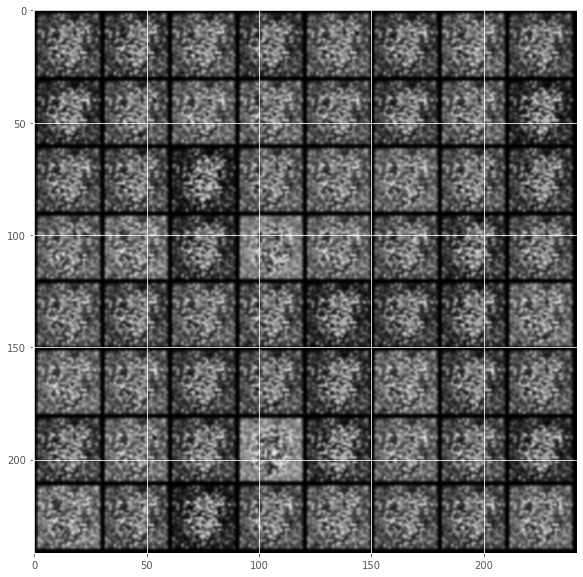

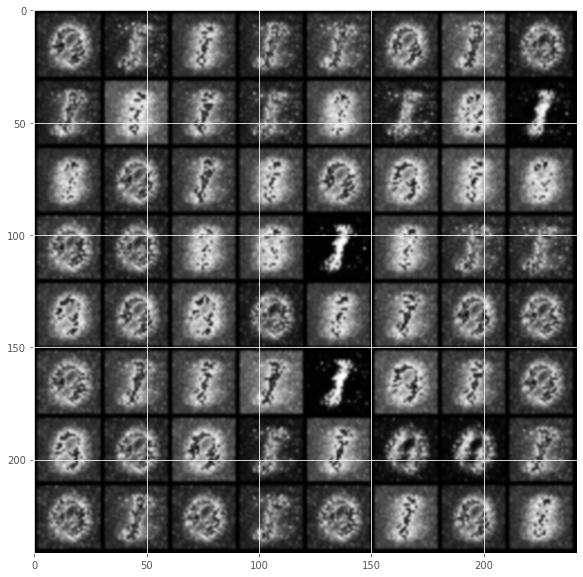

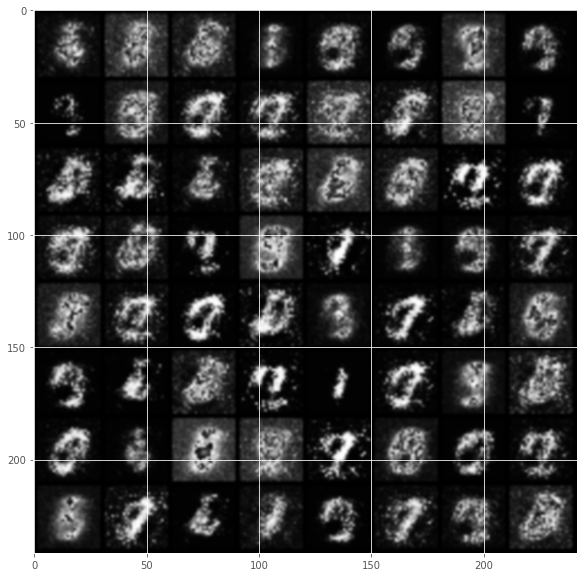

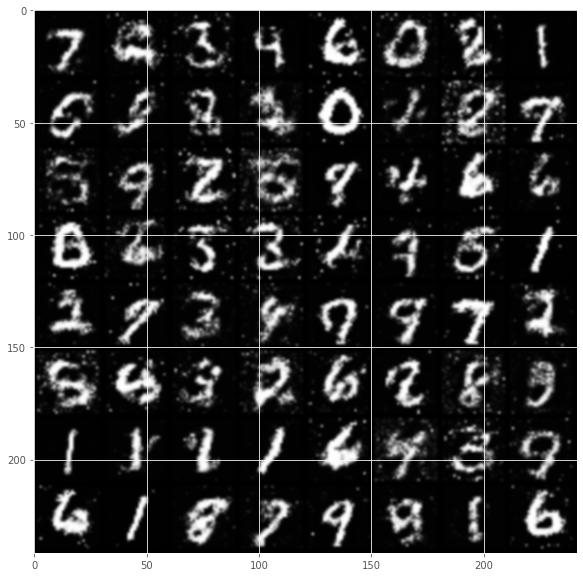

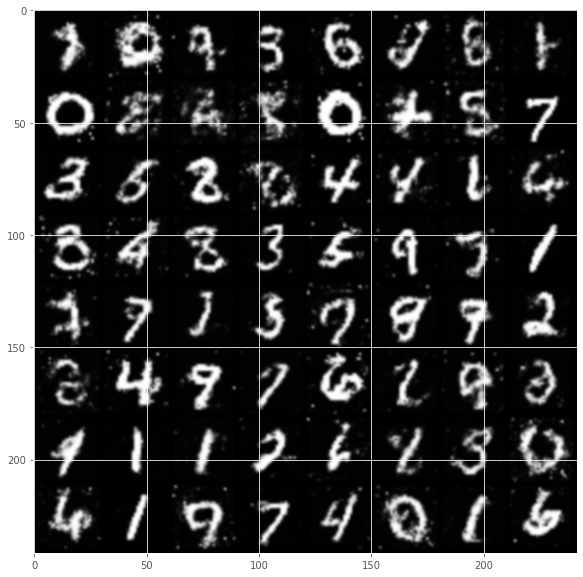

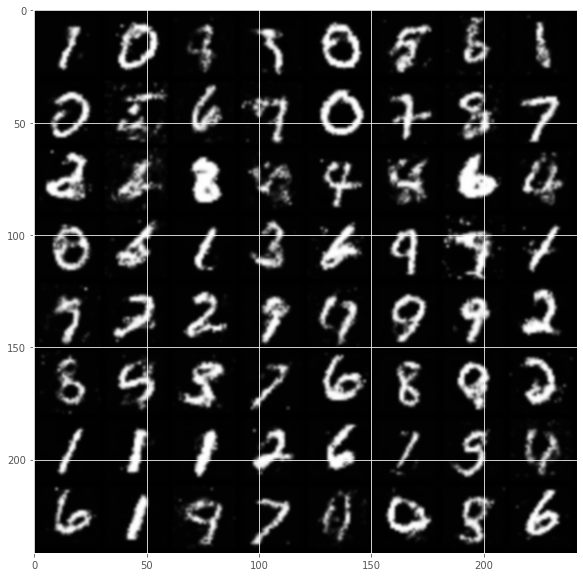

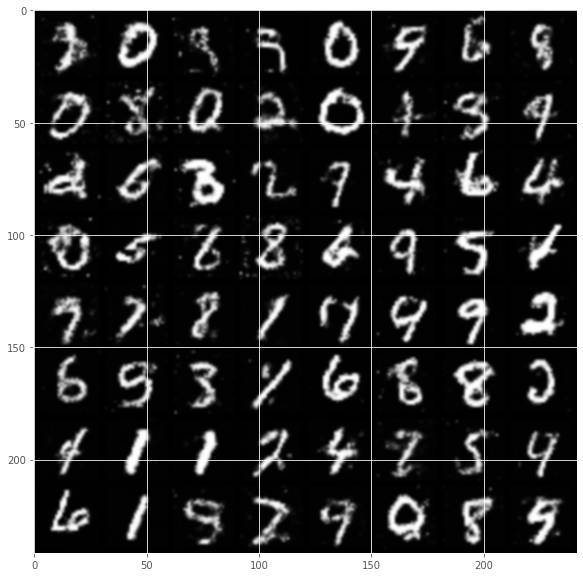

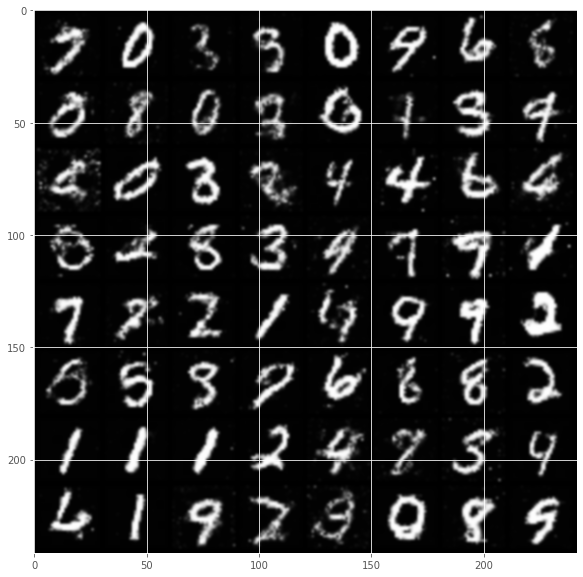

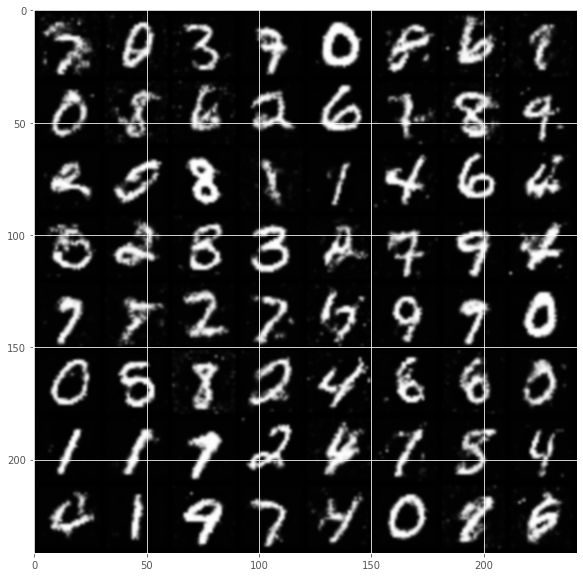

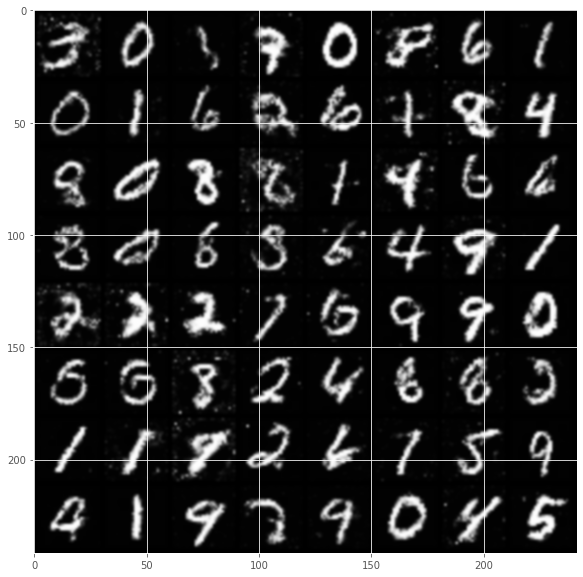

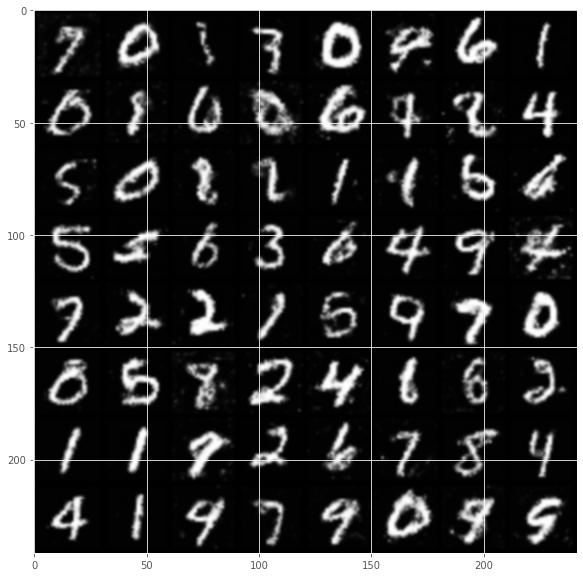

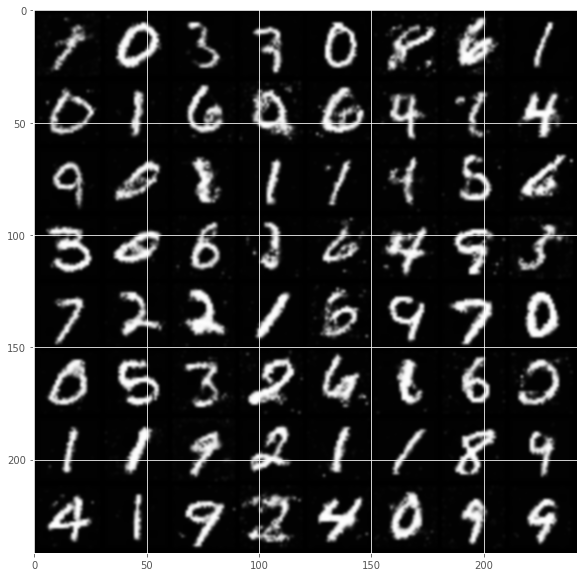

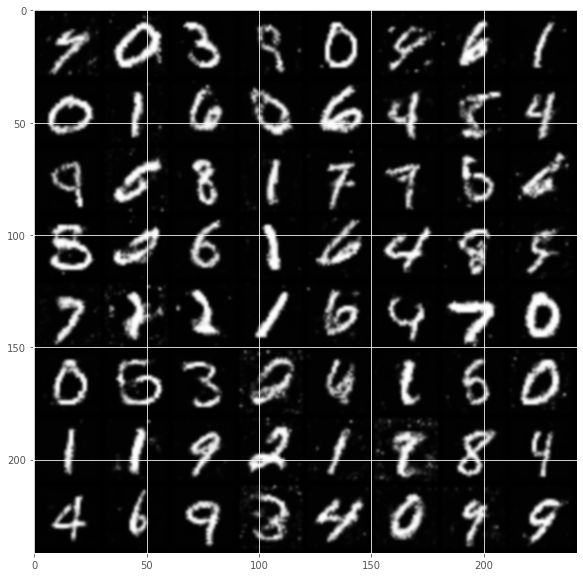

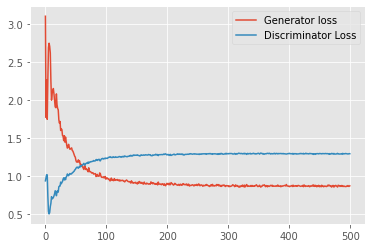

In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
# imageio.mimsave('../outputs/generator_images.gif', imgs)


for img in imgs:
    plt.figure(figsize = (10,10))
    plt.imshow(img,interpolation='bicubic')
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('drive/MyDrive/GAN_outputs1/loss.png')


In [2]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    if(epoch in e_list):
        generated_img = generator(noise).cpu().detach()
        # make the images as grid
        generated_img = make_grid(generated_img)
        # save the generated torch tensor models to disk
        save_generator_image(generated_img, f"drive/MyDrive/GAN_outputs2/gen_img{epoch}.png")
        images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), 'drive/MyDrive/gen_state/generator.pth')

NameError: ignored

In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
# imageio.mimsave('../outputs/generator_images.gif', imgs)


for img in imgs:
    plt.figure(figsize = (10,10))
    plt.imshow(img,interpolation='bicubic')
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('drive/MyDrive/GAN_outputs2/loss.png')
